In [1]:
# ! pip install -e /files/shared/ap/jupyter-notebook/pkgs/objFuncs
# ! pip install -e /files/shared/ap/jupyter-notebook/pkgs/pyBO

 # please re-start kernel if these packages are installed for the first time

In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
import time
import datetime
import concurrent
from phantasy import caget#,fetch_data

In [3]:
import objFuncs
from objFuncs import maximize_FC
from objFuncs.util import plot_obj_history
from pyBO import pyBO

== default machineIOs are...
   _test : False
   _ensure_set_timeout : 30
   _ensure_set_timewait_after_ramp : 0.2
   _fetch_data_time_span : 1
   _return_obj_var : False
   _check_chopper_blocking : True


In [7]:
budget = 64
n_init = 32

# check objFuncs machineIO, source and beam  

In [4]:
objFuncs._global_machineIO._test = False
objFuncs._global_machineIO._fetch_data_time_span = 2.05
objFuncs._global_machineIO._ensure_set_timewait_after_ramp : 0.25
# objFuncs._global_machineIO.view()

In [5]:
SCS = caget("ACS_DIAG:DEST:ACTIVE_ION_SOURCE")
ion = caget("FE_ISRC"+str(SCS)+":BEAM:ELMT_BOOK")
Q = caget("FE_ISRC"+str(SCS)+":BEAM:Q_BOOK")
A = caget("FE_ISRC"+str(SCS)+":BEAM:A_BOOK")
# AQ = caget("FE_ISRC2:BEAM:MOVRQ_BOOK")
AQ = A/Q
ion = str(A)+ion+str(Q)
print('SCS'+str(SCS), ion, 'A/Q=',AQ)

SCS2 28Si11 A/Q= 2.5454545454545454


In [ ]:
%%javascript
IPython.notebook.kernel.execute('nb_name = "' + IPython.notebook.notebook_name + '"')

In [ ]:
now0str = datetime.datetime.now().strftime('%Y%m%d_%H%M')
fname = now0str+'['+ion+']'+nb_name.strip('.ipynb')
fname

# preprare objective

In [8]:
decision_CSETs = [
    'FE_LEBT:PSC2_D0821:I_CSET',
    'FE_LEBT:PSC1_D0821:I_CSET',
    'FE_LEBT:PSC2_D0929:I_CSET',
    'FE_LEBT:PSC1_D0929:I_CSET',
                  ]
frac = 0.9
decision_min = [-frac*AQ]*len(decision_CSETs)
decision_max = [ frac*AQ]*len(decision_CSETs)

list(zip(decision_min, decision_max))  # bounds

[(-2.290909090909091, 2.290909090909091),
 (-2.290909090909091, 2.290909090909091),
 (-2.290909090909091, 2.290909090909091),
 (-2.290909090909091, 2.290909090909091)]

In [9]:
obj = maximize_FC.maximize_FC998(
    decision_CSETs=decision_CSETs,
    decision_min = decision_min,
    decision_max = decision_max,
    objective_goal   = {'FE_LEBT:FC_D0998:PKAVG_RD': {'more than': 35}},
    objective_weight = {'FE_LEBT:FC_D0998:PKAVG_RD': 1},
    objective_norm   = {'FE_LEBT:FC_D0998:PKAVG_RD': 15},
    objective_fill_none_by_init = True,
    history_logging_fname = fname,
)

== decision sets ==


{'FE_LEBT:PSC2_D0821:I_CSET': -1.9040370252322067,
 'FE_LEBT:PSC1_D0821:I_CSET': 1.5194809086620809,
 'FE_LEBT:PSC2_D0929:I_CSET': -0.7814731531522492,
 'FE_LEBT:PSC1_D0929:I_CSET': -2.272436262667179}

== objective_goal ==


OrderedDict([('FE_LEBT:FC_D0998:PKAVG_RD', {'more than': 35})])

== objective_norm ==


OrderedDict([('FE_LEBT:FC_D0998:PKAVG_RD', 15)])

== objective_weight ==


OrderedDict([('FE_LEBT:FC_D0998:PKAVG_RD', 1.0)])

== etc ==
objective_p_order:  2
apply_bilog:  False


 # Prepare plot callbacks

In [10]:
# define what to plot
plot_CSETs = plot_obj_history(
                obj.history['decision_CSETs'],
                title = 'decision_CSETs',
                inline = True,
                )
plot_RDs = plot_obj_history(
                obj.history['objective_RDs'],
                title = 'objective_RDs',
                inline = True,
                )
plot_objs = plot_obj_history(
            obj.history['objectives'],
            title = 'objectives',
            inline = True,
            )
callbacks = [plot_CSETs,plot_RDs,plot_objs]

# evaluate objective and plot
def obj_callbacks(x):
    return obj(x,callbacks=callbacks)

# Run BO

### run BO until budget exhaust

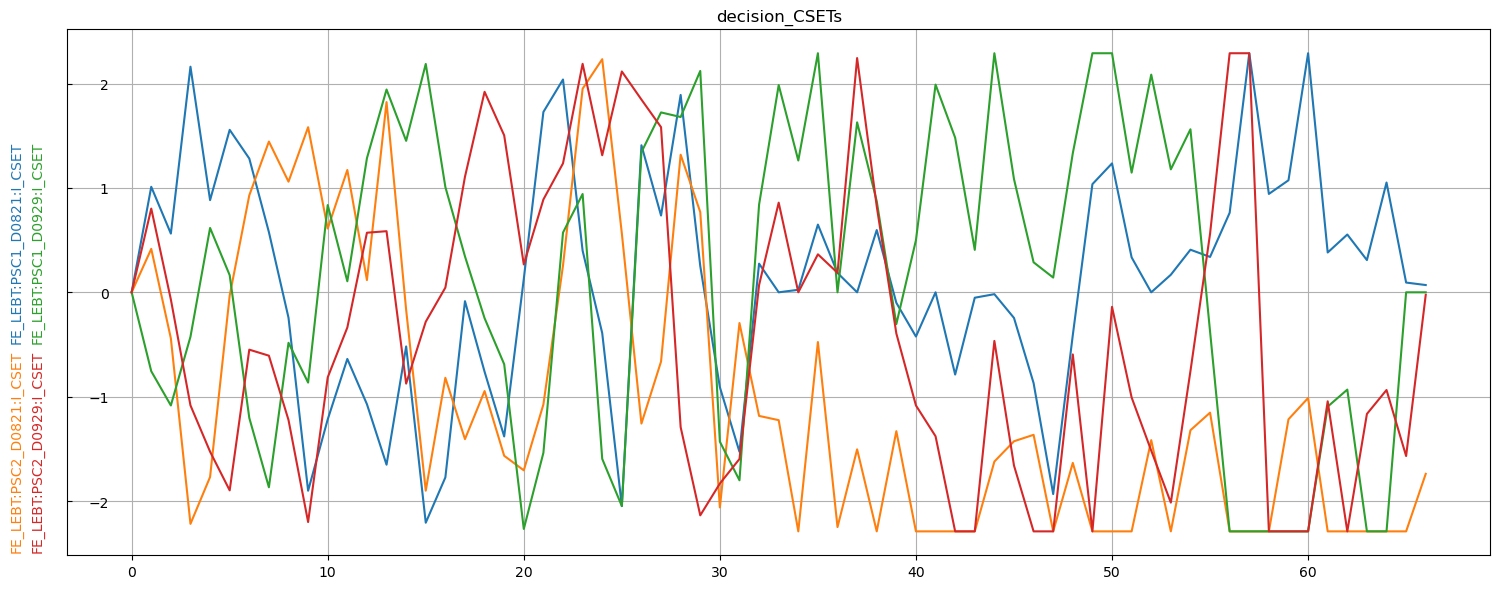

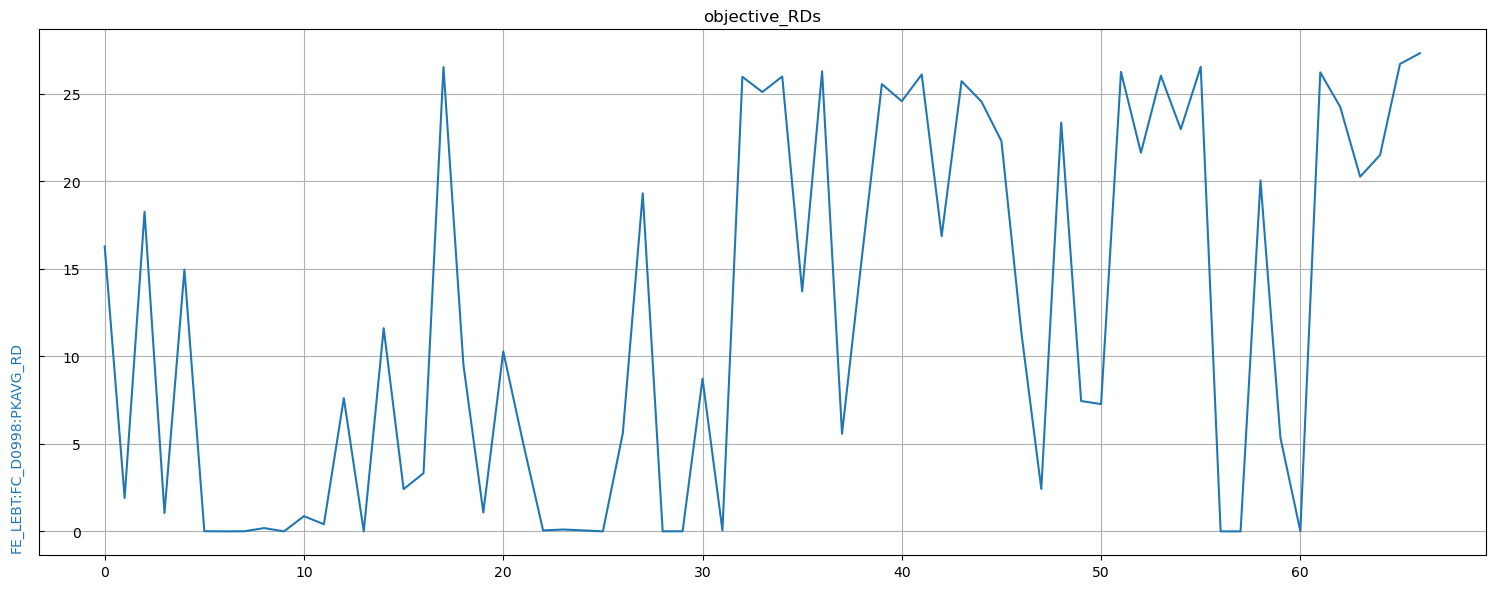

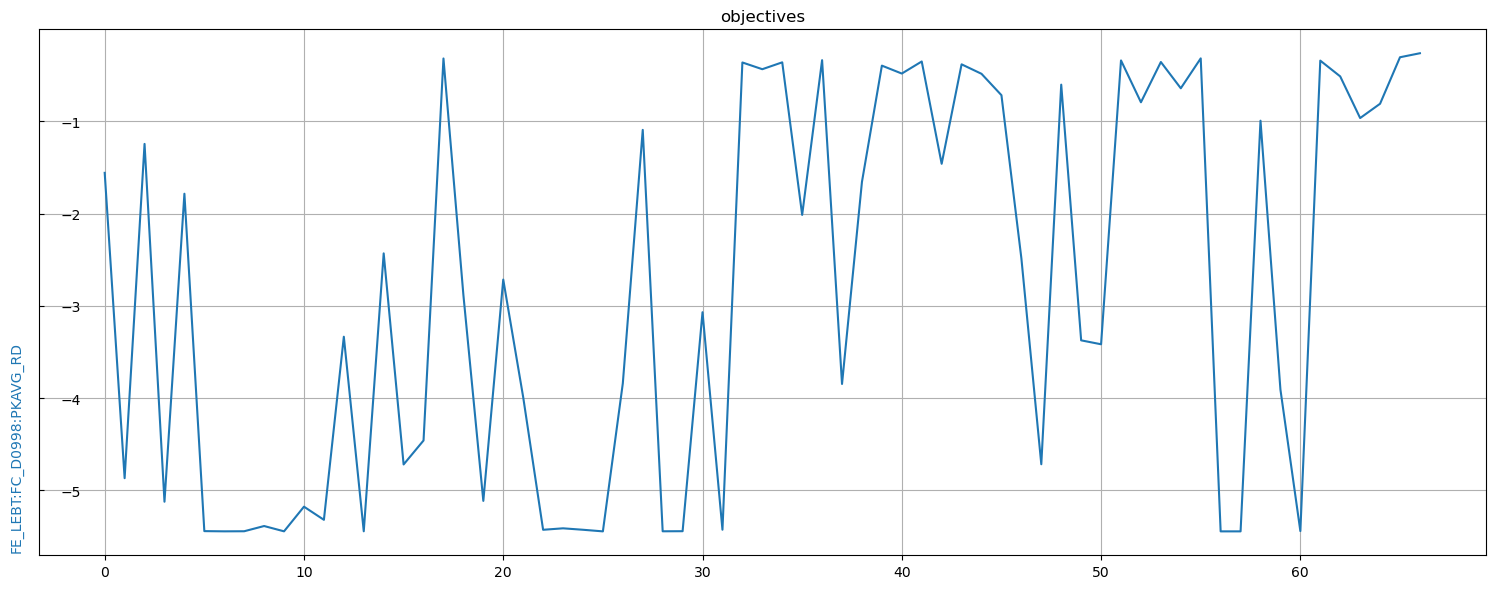

[████████████████████████████████████████] 100%/100%

[████████████████████████████████████████] 100%/100%



In [11]:
# run optimizer
bo, X_pending, Y_pending_future = pyBO.runBO(
                                    obj_callbacks,  
                                    bounds=obj.decision_bounds,
                                    n_init=n_init,
                                    budget = budget,
                                    batch_size=1,
#                                     timeout = 2+objFuncs._global_machineIO._fetch_data_time_span,
                                    path="./log/",
                                    tag=fname+'_pyBO_history',
                                    write_log = False)


# exploit model for a few iteration
acquisition_func_args = {'beta':0.01}
X_pending, Y_pending_future= bo.loop( 
                                n_loop=2,  # number of additional optimization interation
                                func_obj = obj_callbacks,
                                bounds = obj.decision_bounds,
                                acquisition_func_args = acquisition_func_args,
                                X_pending = X_pending, 
                                Y_pending_future = Y_pending_future,
                                batch_size = 1,
                                write_log = False,
                                )

for f in callbacks:
    f.close()

In [12]:
now1 = datetime.datetime.now()
now1str = str(now1)[:str(now1).rfind(':')].replace(' ','_').replace(':','').replace('-','')
time_delta = now1 - now0
print("time took:",str(time_delta.total_seconds()/60)[:4],'min')

time took: 7.12 min


In [13]:
# # uncomment and run if more iteration needed
# X_pending, Y_pending_future= bo.loop( 
#                                 n_loop=4,  # number of additional optimization interation
#                                 func_obj = obj_callbacks,
#                                 X_pending = X_pending, 
#                                 Y_pending_future = Y_pending_future,
#                                 batch_size = 1,
#                                 write_log = False,
#                                 )
# for f in callbacks:
#     f.close()

### Fine Tune near current best

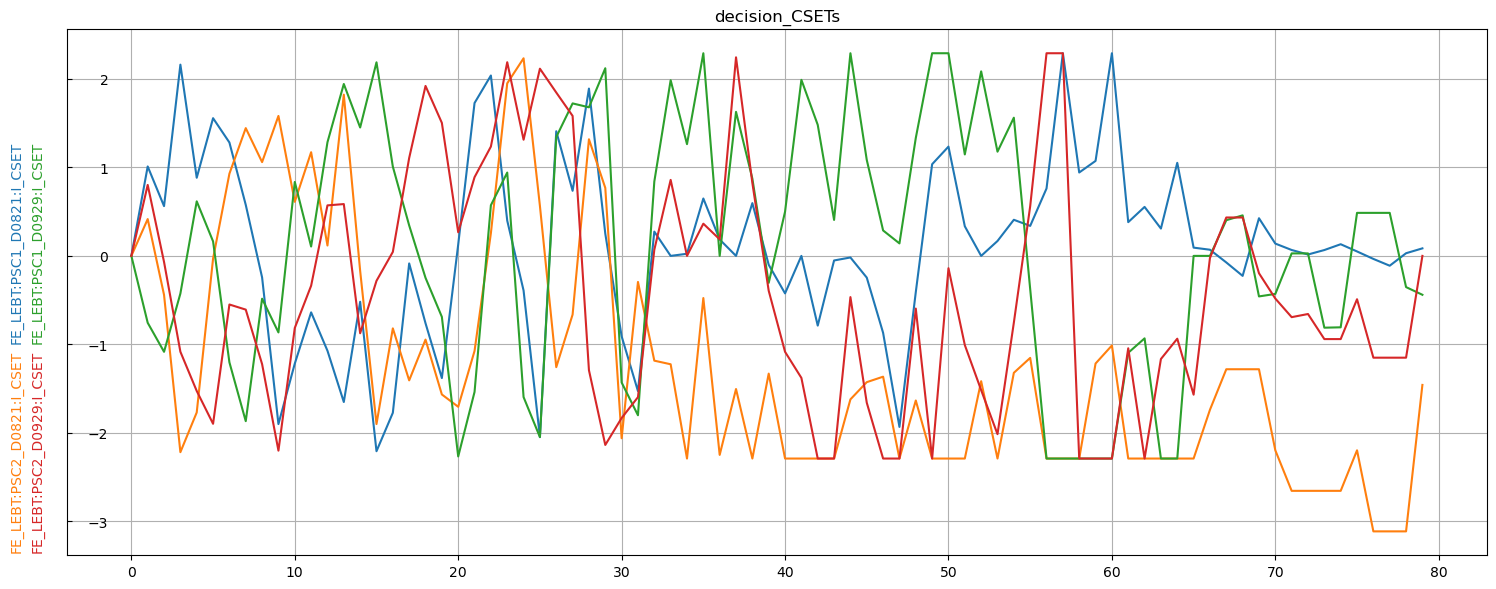

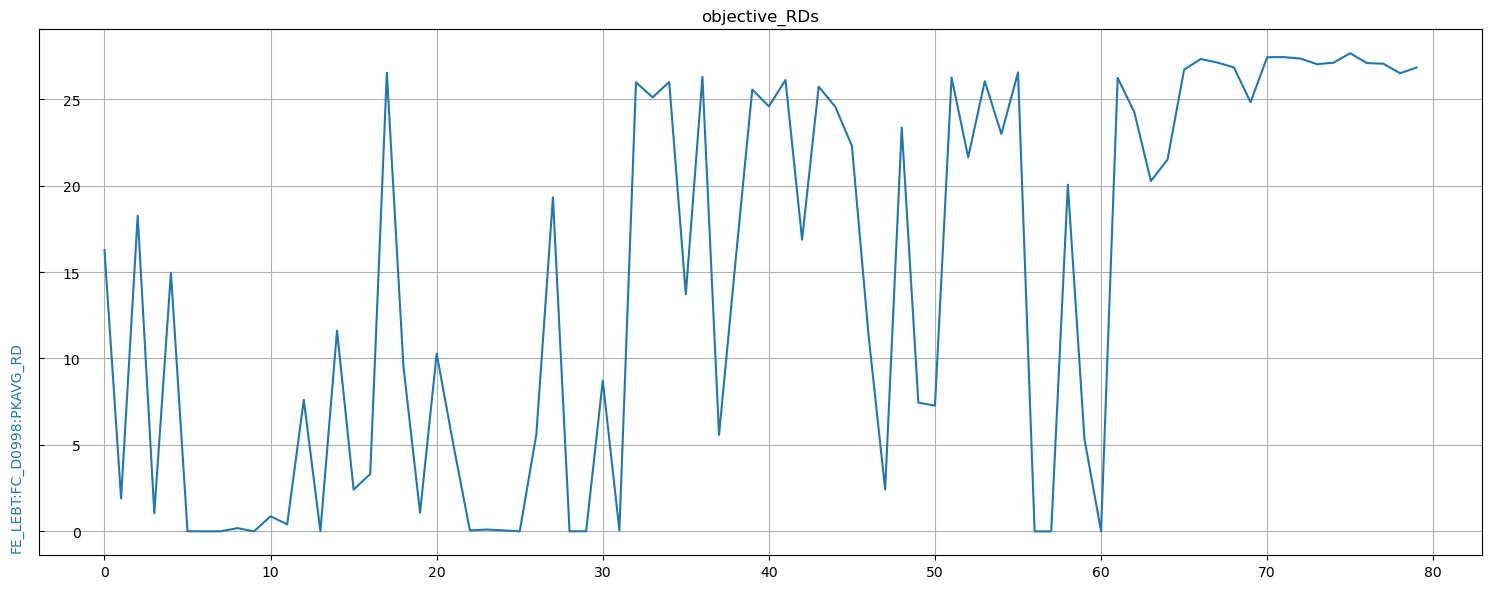

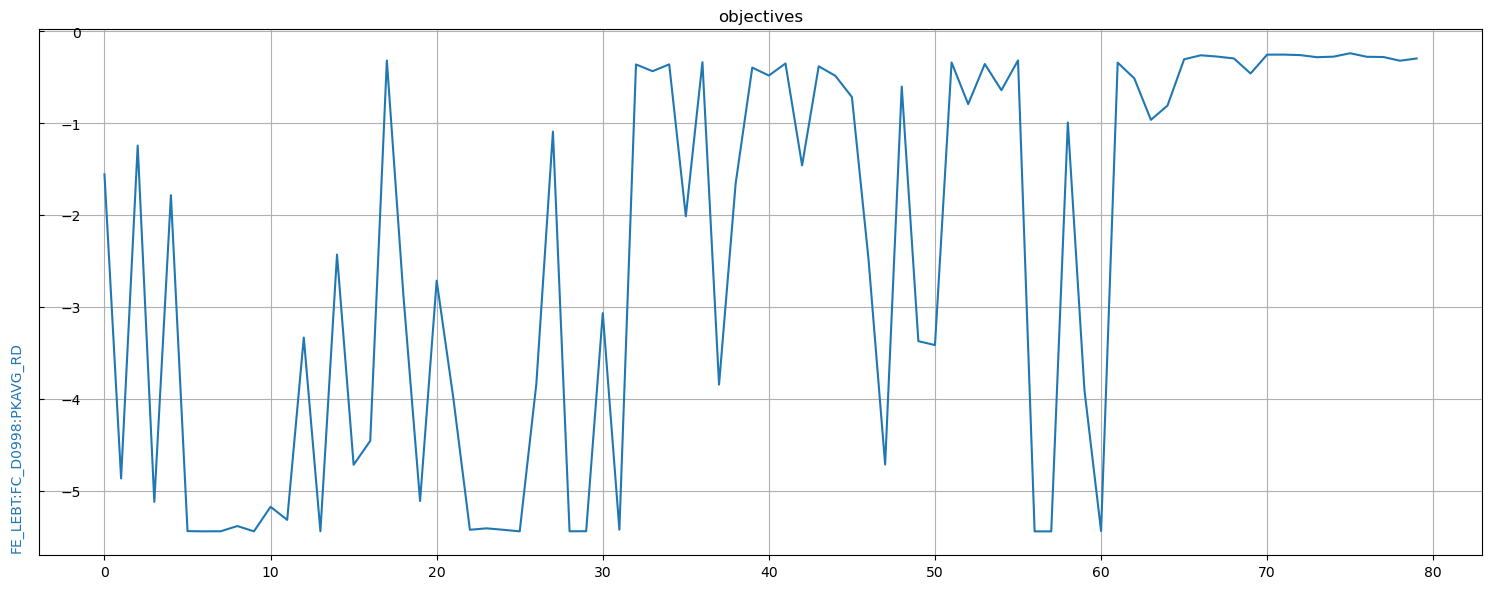

[████████████████████████████████████████] 100%/100%

[████████████████████████████████████████] 100%/100%

[████████████████████████████████████████] 100%/100%

[████████████████████████████████████████] 100%/100%



In [14]:
# local optimization near the best_solution
bounds_diff = obj.decision_bounds[:,1] - obj.decision_bounds[:,0]
for i in range(3):
    x_best,y_best = bo.best_sofar()
    bounds_best = np.array(list(zip(x_best-0.1*bounds_diff, x_best+0.1*bounds_diff)))
    acquisition_func_args = {'beta':1}

    X_pending, Y_pending_future= bo.loop( 
                                    n_loop=4,  # number of additional optimization interation
                                    func_obj = obj_callbacks,
                                    bounds = bounds_best,
                                    acquisition_func_args = acquisition_func_args,
                                    X_pending = X_pending, 
                                    Y_pending_future = Y_pending_future,
                                    batch_size = 1,
                                    write_log = False,
                                    )
    
    
acquisition_func_args = {'beta':0.01}
X_pending, Y_pending_future= bo.loop( 
                                n_loop=1,  # number of additional optimization interation
                                func_obj = obj_callbacks,
                                bounds = bounds_best,
                                acquisition_func_args = acquisition_func_args,
                                X_pending = X_pending, 
                                Y_pending_future = Y_pending_future,
                                batch_size = 1,
                                write_log = False,
                                )
    
for f in callbacks:
    f.close()

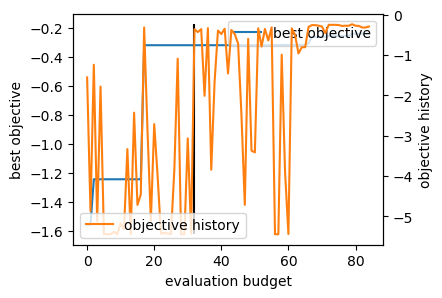

In [15]:
ax = bo.plot_obj_history()
ax.vlines(n_init,*ax.get_ylim(),color='k')

In [16]:
# set to best solution 
x_best,y_best_old = bo.best_sofar()
y_best_new = obj(x_best)
print(x_best,y_best_old[0],y_best_new)   # check if best solution objective value is consistent

[ 0.0502386  -2.19785815  0.48632073 -0.49007368] -0.2395475719575665 -0.23656598863635298


In [17]:
obj.write_log(fname=os.path.join('./log',fname))

# Visualize Surrogate model

In [18]:
# fixed_values_for_each_dim = {2:x_best[2],3:x_best[3]}  # fix values to visualize high dim surrogate model
fixed_values_for_each_dim = None                         # do not fix values but project maximum. Can take long time to plot
batch_size = 1

In [19]:
# # plot acuquisition functions for the first 4 epochs. Can take long time for decision dim >= 4
# for epoch in range(4):   
#     fig,ax = plt.subplots(1,batch_size,figsize=(4*batch_size,3))
#     if batch_size ==1:
#         ax = [ax]
#     for i in range(batch_size):
#         bo.plot_acquisition_2D_projection(project_maximum=True,
#                                           epoch=epoch,
#                                           i_query=i,
#                                           grid_ponits_each_dim = 16,
#                                           fixed_values_for_each_dim=fixed_values_for_each_dim,
#                                           fig=fig,ax=ax[i],);
#         ax[i].legend()
#         ax[i].set_xlabel(obj.decision_CSETs[0])
#         ax[i].set_ylabel(obj.decision_CSETs[1])
#     fig.tight_layout()

In [20]:
# # plot acuquisition functions for the last 4 epochs. Can take long time for decision dim >= 4
# for epoch in range(-6,-2):
#     fig,ax = plt.subplots(1,batch_size,figsize=(4*batch_size,3))
#     if batch_size ==1:
#         ax = [ax]
#     for i in range(batch_size):
#         bo.plot_acquisition_2D_projection(project_maximum=True,
#                                           epoch=epoch,
#                                           i_query=i,
#                                           grid_ponits_each_dim = 16,
#                                           fixed_values_for_each_dim=fixed_values_for_each_dim,
#                                           fig=fig,ax=ax[i],);
#         ax[i].legend()
#         ax[i].set_xlabel(obj.decision_CSETs[0])
#         ax[i].set_ylabel(obj.decision_CSETs[1])
#     fig.tight_layout()

[████████████████████████████████████████] 100%/100%

[████████████████████████████████████████] 100%/100%

time took:  1.0280625121667981


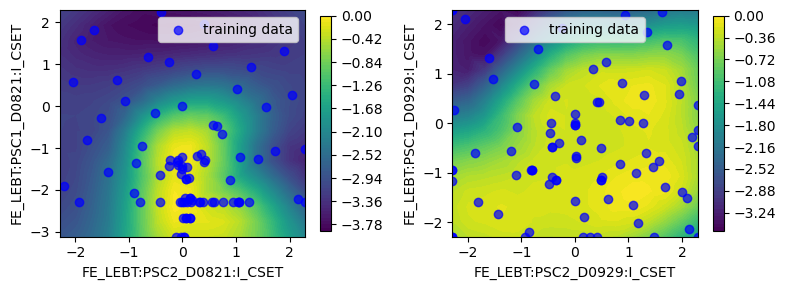

In [21]:
# plot surrogate mean model of the last epoch. Can take long time for decision dim >= 4

t0 = time.monotonic()
from math import ceil
nplot = int(0.5*len(obj.decision_CSETs))
nrow = ceil(0.5*nplot)
fig,ax = plt.subplots(nrow,2,figsize=(8,3*nrow))
for i in range(nrow):
    for j in range(2):
        n = 2*i+j
        if nrow>1:
            ax_ = ax[i,j]
        else:
            ax_ = ax[j]
        if n >= nplot:
            ax_.set_visible(False)
            break
        bo.plot_model_2D_projection(project_maximum=True,
                                    dim_xaxis = 2*n,
                                    dim_yaxis = 2*n+1,
                                    grid_ponits_each_dim = 16,
                                    fixed_values_for_each_dim=fixed_values_for_each_dim,
                                            fig=fig,ax=ax_);
        ax_.set_xlabel(obj.decision_CSETs[2*n  ])
        ax_.set_ylabel(obj.decision_CSETs[2*n+1])
        ax_.legend()
fig.tight_layout()

    
print('time took: ',time.monotonic()-t0)